In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
! ls '/content/drive/MyDrive/Satellite Semantic Segmentation'

attention_unet_train.ipynb  data.ipynb	     readme_images     runs		  unet_train.ipynb
config			    models	     README.md	       src
data			    MODELS_REGISTER  requirements.txt  test_inference.py


In [24]:
import sys
sys.path.append('/content/drive/MyDrive/Satellite Semantic Segmentation')

In [25]:
! pip install -r "/content/drive/MyDrive/Satellite Semantic Segmentation/requirements.txt"

In [26]:
base_path = "/content/drive/MyDrive/Satellite Semantic Segmentation/"

In [27]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchinfo import summary

from matplotlib import pyplot as plt
from timeit import default_timer as timer
import random

from config import data_config, unet_config

from src.utils import *
from src.datafactory import SatelliteDataset, SatellitePatchesDataset, create_dataloaders
from src import engine
from models.unet import Unet
from src.transforms import train_transforms, val_transforms

import logging

from codecarbon import EmissionsTracker

## Disable logging from codecarbon
logging.getLogger("codecarbon").setLevel(logging.CRITICAL)

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
NUM_WORKERS = os.cpu_count()

# Setup data configs
data_config = data_config.data_config()

# Setup hyperparameters
unet_hyperparams = unet_config.unet_config()

seed_everything(seed = unet_hyperparams.global_seed)


# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(base_path + unet_hyperparams.LOGS_DIR)

# Setup device-agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device = ", unet_hyperparams.DEVICE)

Device =  cuda


### Load Patch Images

In [30]:

patches_images = torch.load(base_path + data_config.PATCHES_DATA_PATH + 'patches_images.pt')
patches_masks = torch.load(base_path + data_config.PATCHES_DATA_PATH + 'patches_masks.pt')

print(patches_images.shape, patches_masks.shape)

(1305, 256, 256, 3) (1305, 256, 256)


### Visualize Patches Images

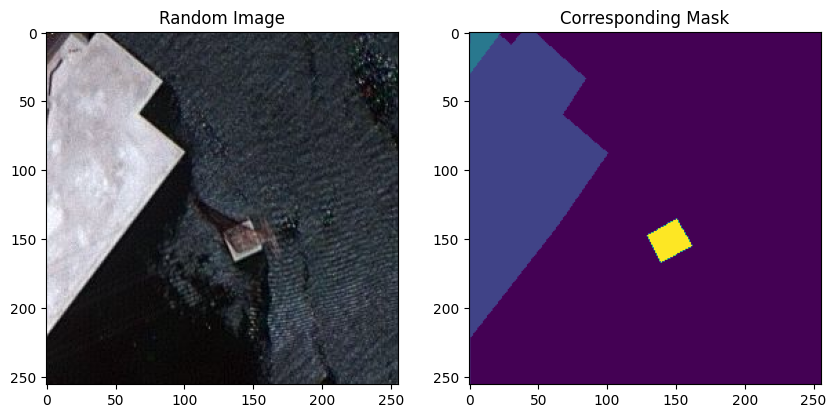

In [31]:
display_random_image_and_mask(patches_images, patches_masks,tensorboard_writer=writer)

### Load Train, Val and Test sets

In [32]:
Xtrain_patches = torch.load(base_path + data_config.TRAIN_DATA_PATH + 'Xtrain_patches.pt')
ytrain_patches = torch.load(base_path + data_config.TRAIN_DATA_PATH + 'ytrain_patches.pt')

Xval_patches = torch.load(base_path + data_config.VAL_DATA_PATH + 'Xval_patches.pt')
yval_patches = torch.load(base_path + data_config.VAL_DATA_PATH + 'yval_patches.pt')

Xtest_patches = torch.load(base_path + data_config.TEST_DATA_PATH + 'Xtest_patches.pt')
ytest_patches  = torch.load(base_path + data_config.TEST_DATA_PATH + 'ytest_patches.pt')

Xtrain_patches.shape, Xval_patches.shape, Xtest_patches.shape, ytrain_patches.shape, yval_patches.shape, ytest_patches.shape

((913, 256, 256, 3),
 (261, 256, 256, 3),
 (131, 256, 256, 3),
 (913, 256, 256),
 (261, 256, 256),
 (131, 256, 256))

In [33]:
ytrain_patches[0]

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

### Setup data transformation

### Instantiate train and test dataset

In [34]:
train_dataset = SatellitePatchesDataset(patches_images=Xtrain_patches,
                  patches_masks=ytrain_patches,
                  transform=train_transforms)

val_dataset = SatellitePatchesDataset(patches_images= Xval_patches,
                  patches_masks= yval_patches,
                  transform=val_transforms)

test_dataset = SatellitePatchesDataset(patches_images= Xtest_patches,
                  patches_masks= ytest_patches,
                  transform=val_transforms)

In [35]:

random.seed(42)
visualize_augmentations(train_dataset, idx=55)

Output hidden; open in https://colab.research.google.com to view.

### Create Train & Test dataloaders

In [36]:
train_dataloader = create_dataloaders(dataset=train_dataset,
                                      batch_size= unet_hyperparams.BATCH_SIZE,
                                      num_workers=NUM_WORKERS,)

val_dataloader = create_dataloaders(dataset=val_dataset,
                                     batch_size= unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

test_dataloader = create_dataloaders(dataset=test_dataset,
                                     batch_size= unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

In [37]:
batchX0, batchy0 = next(iter(train_dataloader))
batchX0.shape, batchy0.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [38]:
batchy0[0].unique()

tensor([1., 2., 3.], dtype=torch.float64)

### Intanciate Model and add graph to tensorboard

In [39]:
model = Unet(in_channels = unet_hyperparams.IN_CHANNELS,
             n_classes = unet_hyperparams.NUM_CLASSES,
             upsample= unet_hyperparams.UPSAMPLE,
             upsample_mode = unet_hyperparams.UPSAMPLE_MODE,
             level_channels = unet_hyperparams.LEVEL_CHANNELS,
             bottleneck_channel = unet_hyperparams.BOTTLENECK_CHANNEL,).to(unet_hyperparams.DEVICE)

input_example = torch.randn((2, 3, 256, 256)).to(unet_hyperparams.DEVICE)
writer.add_graph(model, input_example)

summary(model, input_size=input_example.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [2, 6, 256, 256]          --
├─encoder2d_block: 1-1                   [2, 64, 256, 256]         --
│    └─conv2d_block: 2-1                 [2, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [2, 32, 256, 256]         896
│    │    └─BatchNorm2d: 3-2             [2, 32, 256, 256]         64
│    │    └─ReLU: 3-3                    [2, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                  [2, 64, 256, 256]         18,496
│    │    └─BatchNorm2d: 3-5             [2, 64, 256, 256]         128
│    │    └─ReLU: 3-6                    [2, 64, 256, 256]         --
│    └─MaxPool2d: 2-2                    [2, 64, 128, 128]         --
├─encoder2d_block: 1-2                   [2, 128, 128, 128]        --
│    └─conv2d_block: 2-3                 [2, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [2, 64, 128, 128]         36,928
│    

### Start training with help from engine.py


In [ ]:

# setup CO2 emissions tracker
tracker = EmissionsTracker()
tracker.start()

# Start the timer
start_time = timer()

results = engine.train(model=model,
             train_loader=train_dataloader,
             val_loader=test_dataloader,
             optimizer=unet_hyperparams.OPTIMIZER(model.parameters(), lr=unet_hyperparams.LEARNING_RATE),
             criterion= unet_hyperparams.LOSS_FN,
             metrics=unet_hyperparams.METRICS,
             num_classes=unet_hyperparams.NUM_CLASSES,
             num_epochs=unet_hyperparams.NUM_EPOCHS,
             tensorboard_writer=writer,
             device=unet_hyperparams.DEVICE)

end_time = timer()

emissions: float = tracker.stop()

writer.flush()

[codecarbon INFO @ 17:13:28] [setup] RAM Tracking...
[codecarbon INFO @ 17:13:28] [setup] GPU Tracking...
[codecarbon INFO @ 17:13:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:13:28] [setup] CPU Tracking...
[codecarbon WARNING @ 17:13:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:13:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:13:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 17:13:29] >>> Tracker's metadata:
[codecarbon INFO @ 17:13:29]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 17:13:29]   Python version: 3.10.12
[codecarbon INFO @ 17:13:29]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 17:13:29]   Available RAM : 83.477 GB
[codecarbon INFO @ 17:13:29]   CPU count: 12
[codecarbon INFO @ 17:13:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 17:13:29]   GPU 


Epoch 1/100 - Training Loss: 1.4436 - Validation Loss: 1.5993
Train Dice Coeff.: 0.5476 - Val Dice Coeff.: 0.5476


  1%|          | 1/100 [00:14<24:11, 14.67s/it]


KeyboardInterrupt: 

### Log train_time and CO2 emissions to tensorboard

In [ ]:
train_time = print_train_time(start=start_time, end=end_time, device=unet_hyperparams.DEVICE)
writer.add_scalar('Training time', train_time, 0)

print("CO2 Emissions : ", emissions)
writer.add_scalar('CO2 Emissions', emissions, 0)


Time on cuda: 924.783 seconds
CO2 Emissions :  0.039573559588783225


In [ ]:
# Save the model with help from utils.py
save_model(model=model,
                 target_dir=base_path +  unet_hyperparams.MODEL_SAVE_FOLDER + '/',
                 model_name=unet_hyperparams.MODEL_NAME)

[INFO] Saving model to: /content/drive/MyDrive/Satellite Semantic Segmentation/MODELS_REGISTER/unet_model.pth


In [ ]:
writer.close()

In [ ]:
!tensorboard --logdir='base_path + unet_hyperparams.LOGS_DIR'

2024-02-29 15:18:28.403876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 15:18:28.403925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 15:18:28.405417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 15:18:29.404233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0229 15:18:32.763562 138313440683584 plugin.py

In [ ]:
#!tensorboard dev upload --logdir runs \
#--name "Satellite Semantic Segmentatio Experiment" \
#--description "Loging of all Important features"

### Inference

In [40]:
from src.inference import predict
from src.utils import load_model

In [41]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Satellite Semantic Segmentation/MODELS_REGISTER/unet_model.pth'))

<All keys matched successfully>

Predicting: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Multiclass Accuracy: 0.7052
Dice: 0.6780
Jaccard Index: 0.4865
Confusion Matrix:


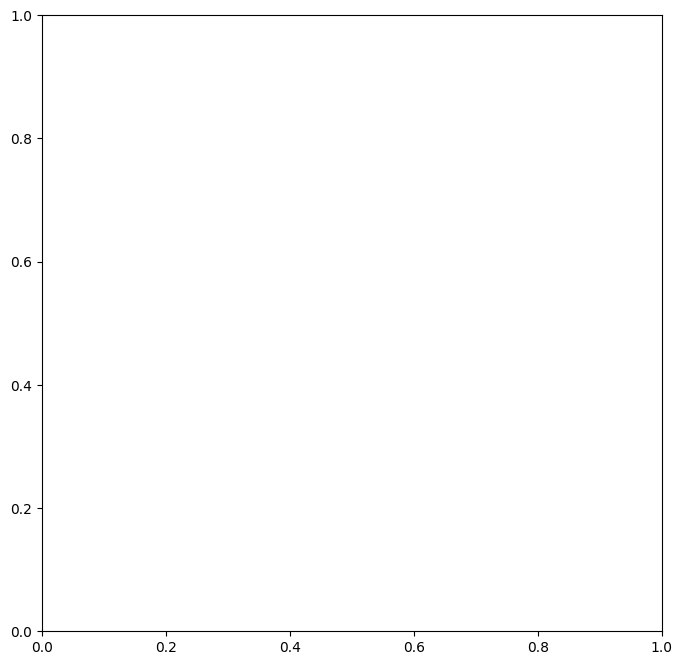

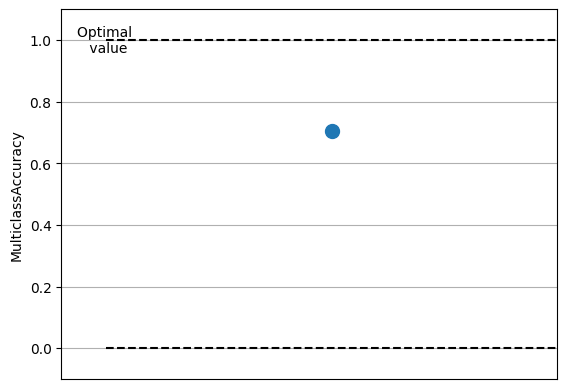

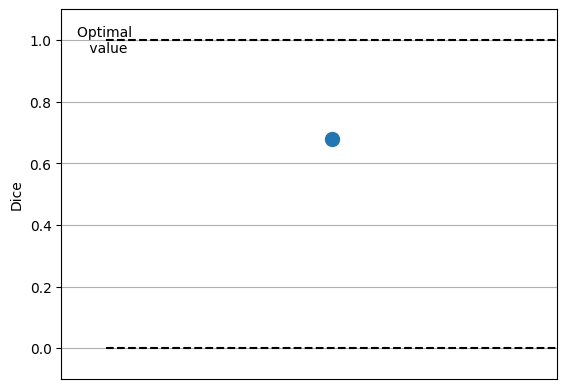

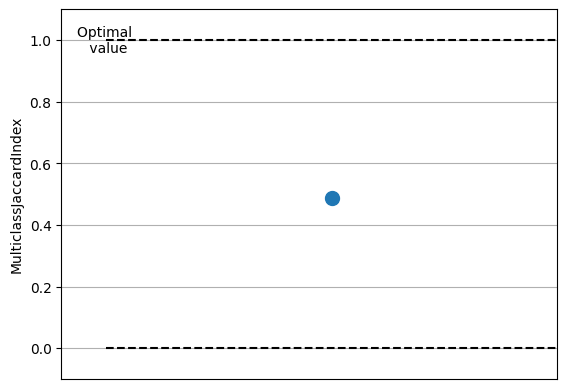

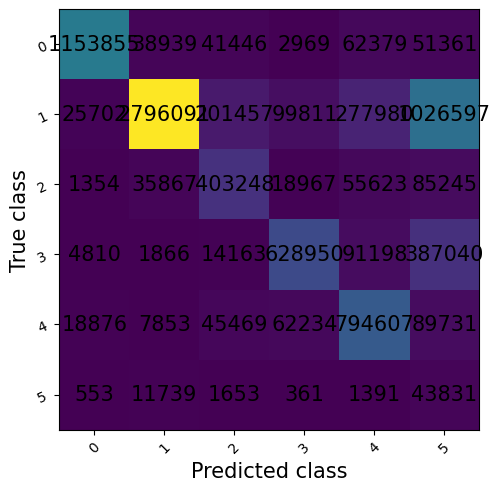

In [42]:
metrics_list = predict(model = model,
                       dataloader = test_dataloader,
                       num_classes = unet_hyperparams.NUM_CLASSES,
                       device = unet_hyperparams.DEVICE)